In [7]:
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

!pip install -r requirements.txt --quiet
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib umap-learn hdbscan pillow scikit-learn --quiet


Cloning into 'ImageBind'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 187 (delta 84), reused 54 (delta 53), pack-reused 67 (from 3)
Receiving objects: 100% (187/187), 2.65 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/ImageBind
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 29.6 MB/s eta 0:00:00


# Cell 2 — Import modules

In [8]:
import os, glob
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from imagebind.data import load_and_transform_vision_data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

from sklearn.cluster import KMeans
import hdbscan
import umap


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Cell 3 — Load pretrained model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval().to(device)
print("✅ Model loaded successfully on", device)


100%|██████████| 4.47G/4.47G [01:15<00:00, 63.5MB/s]


✅ Model loaded successfully on cpu


# Cell 4 — Prepare images

Found 10 images


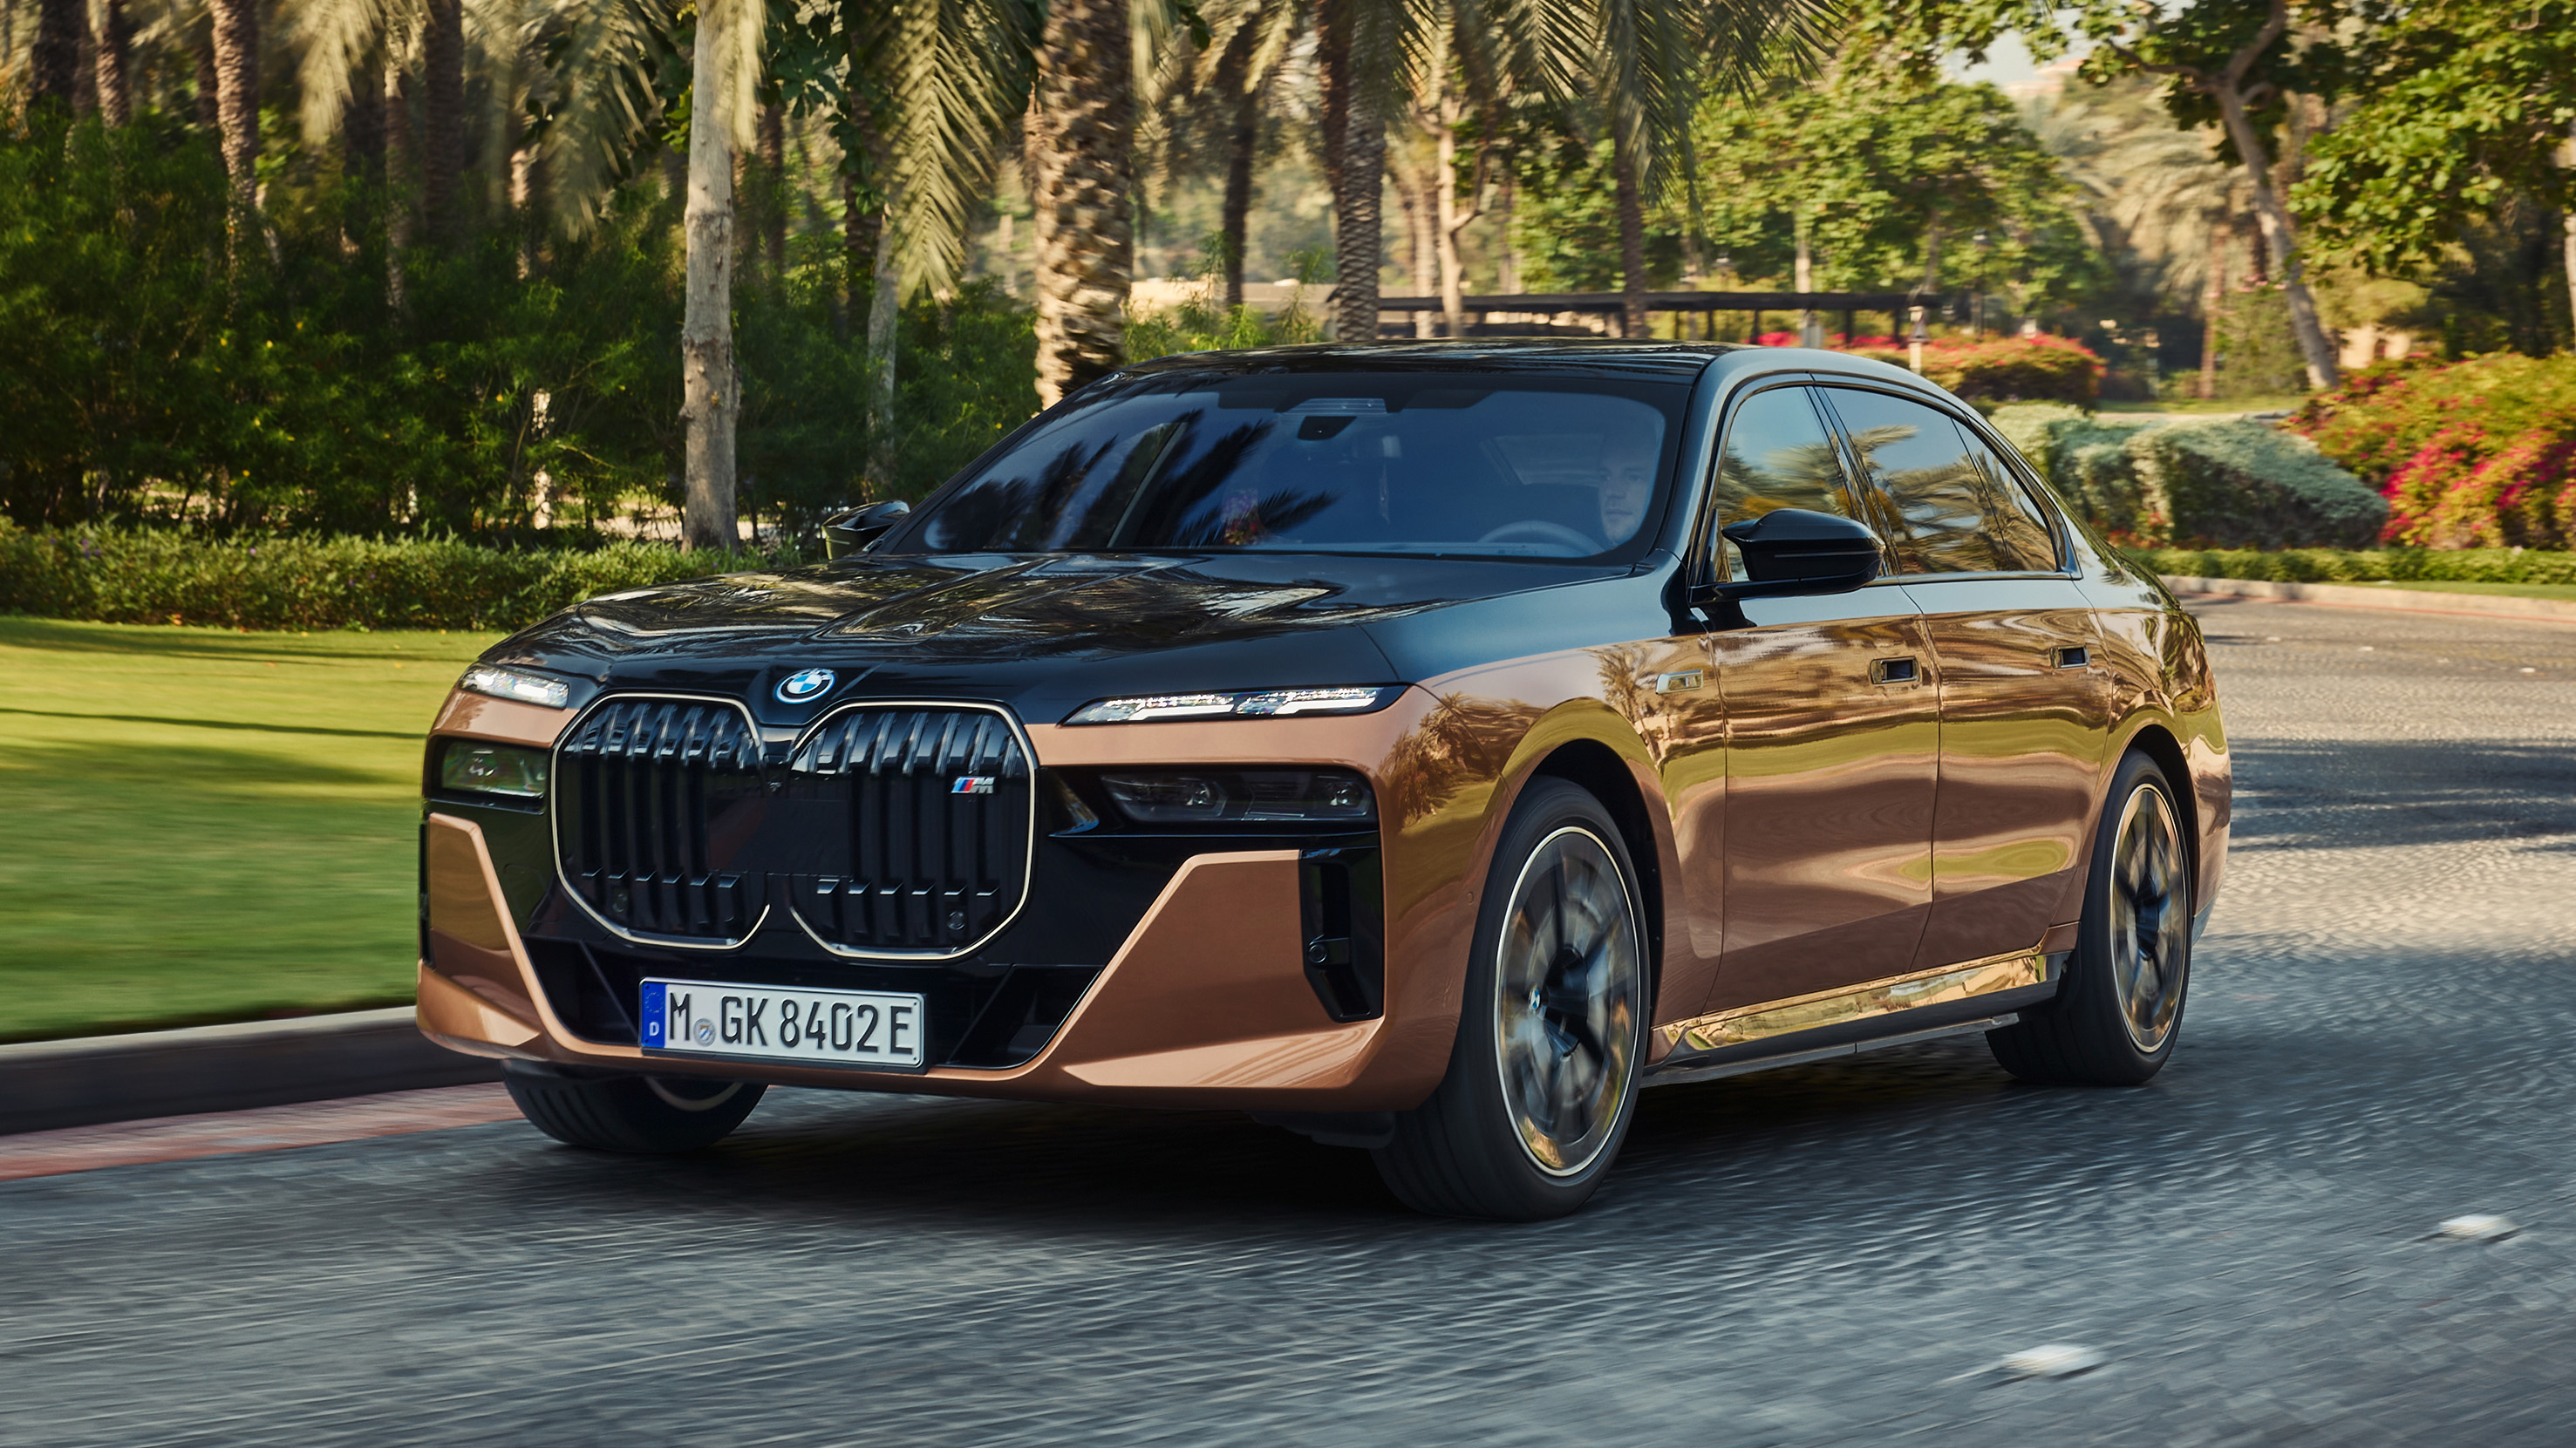

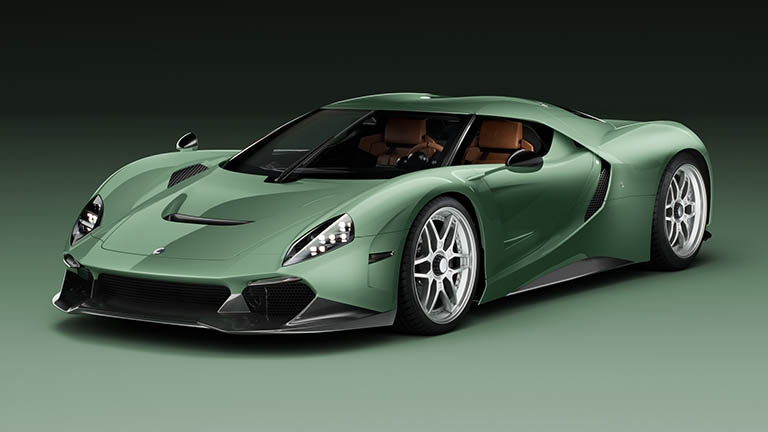

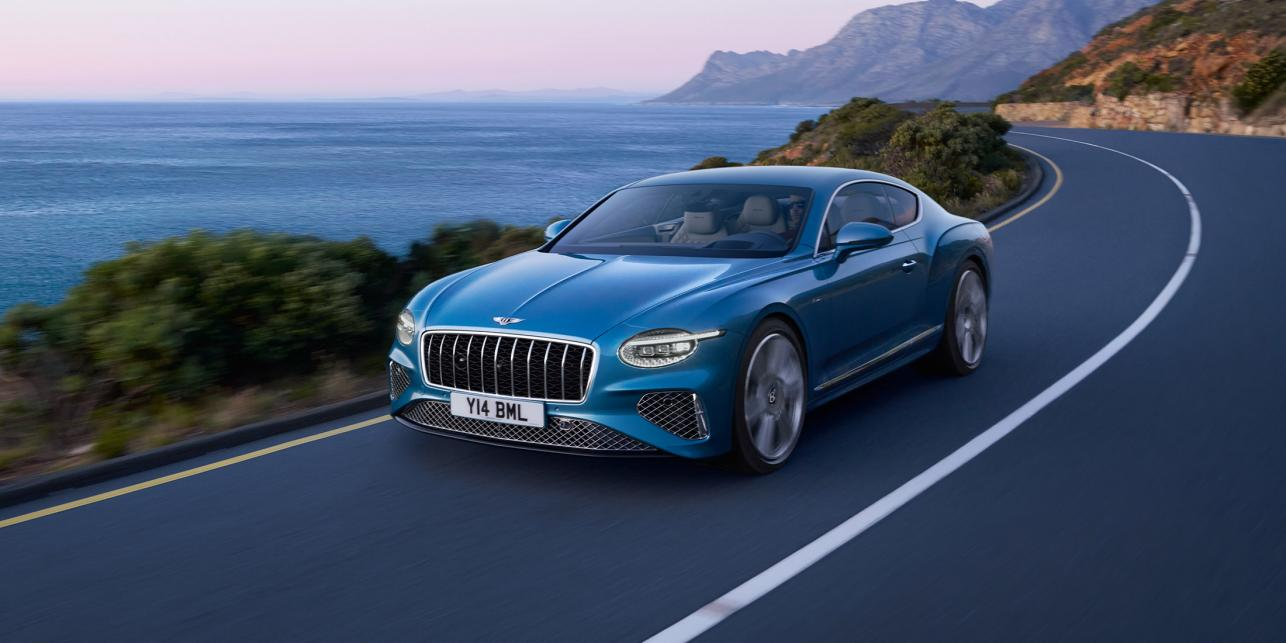

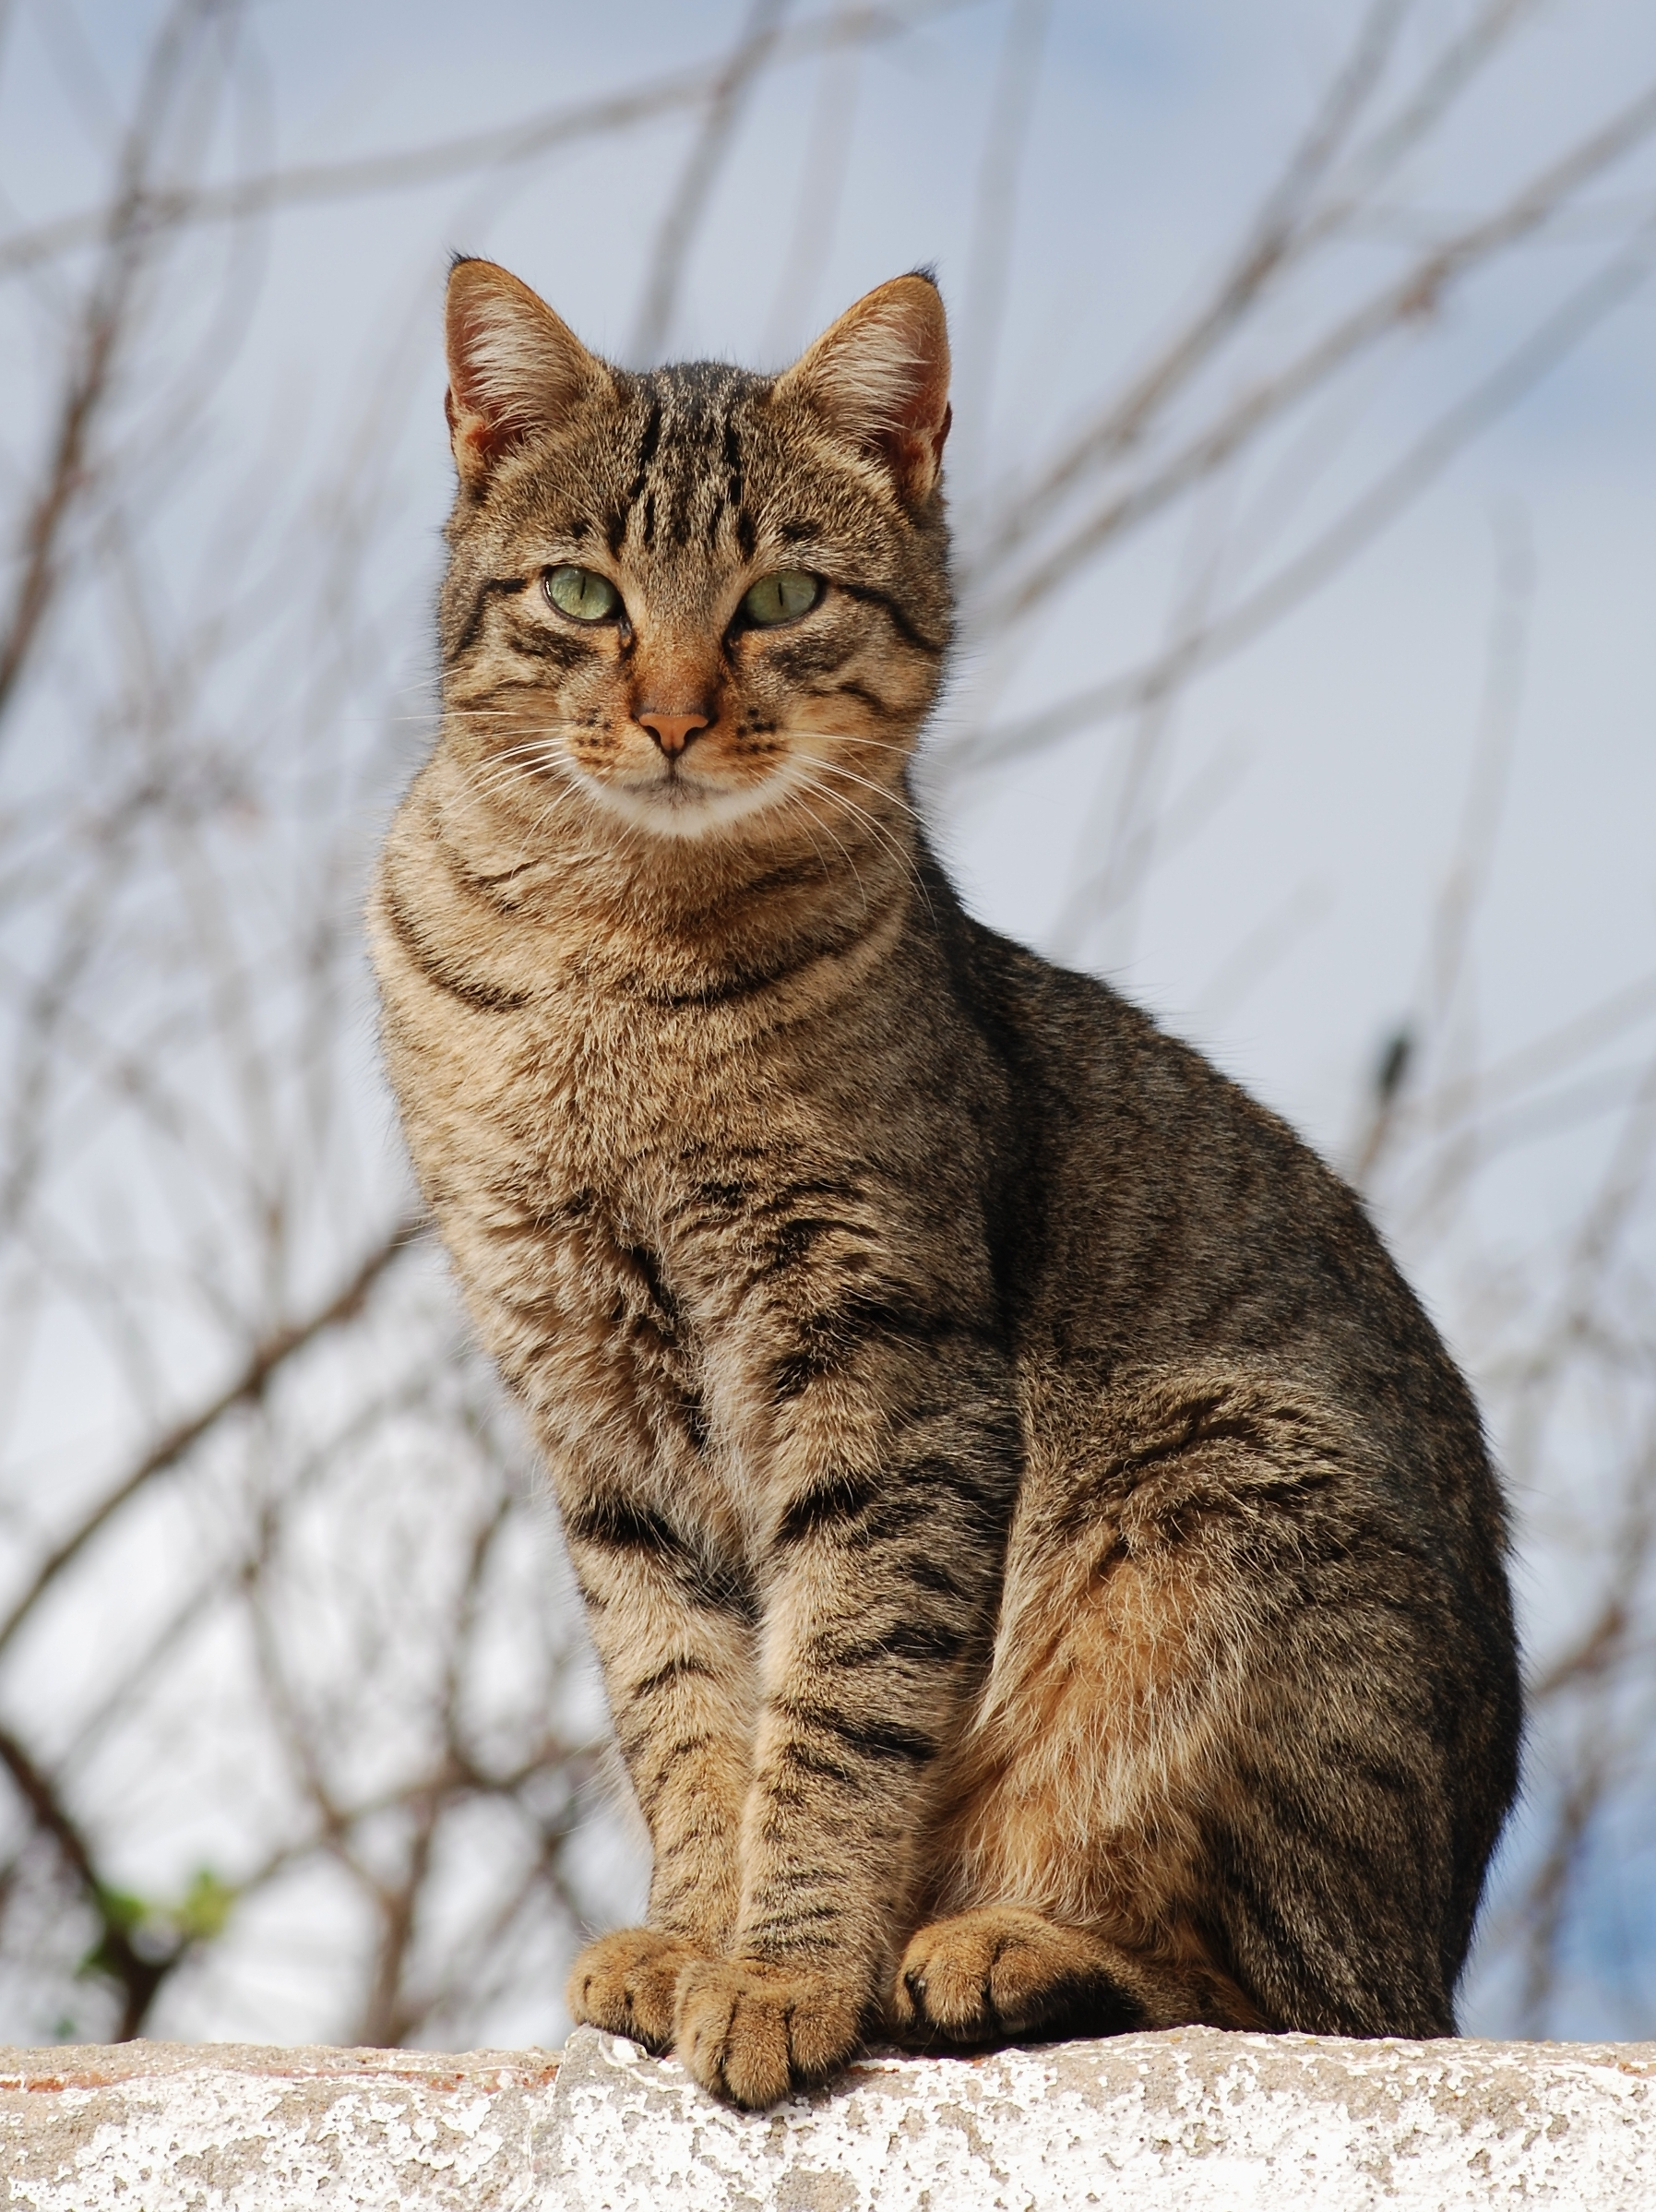

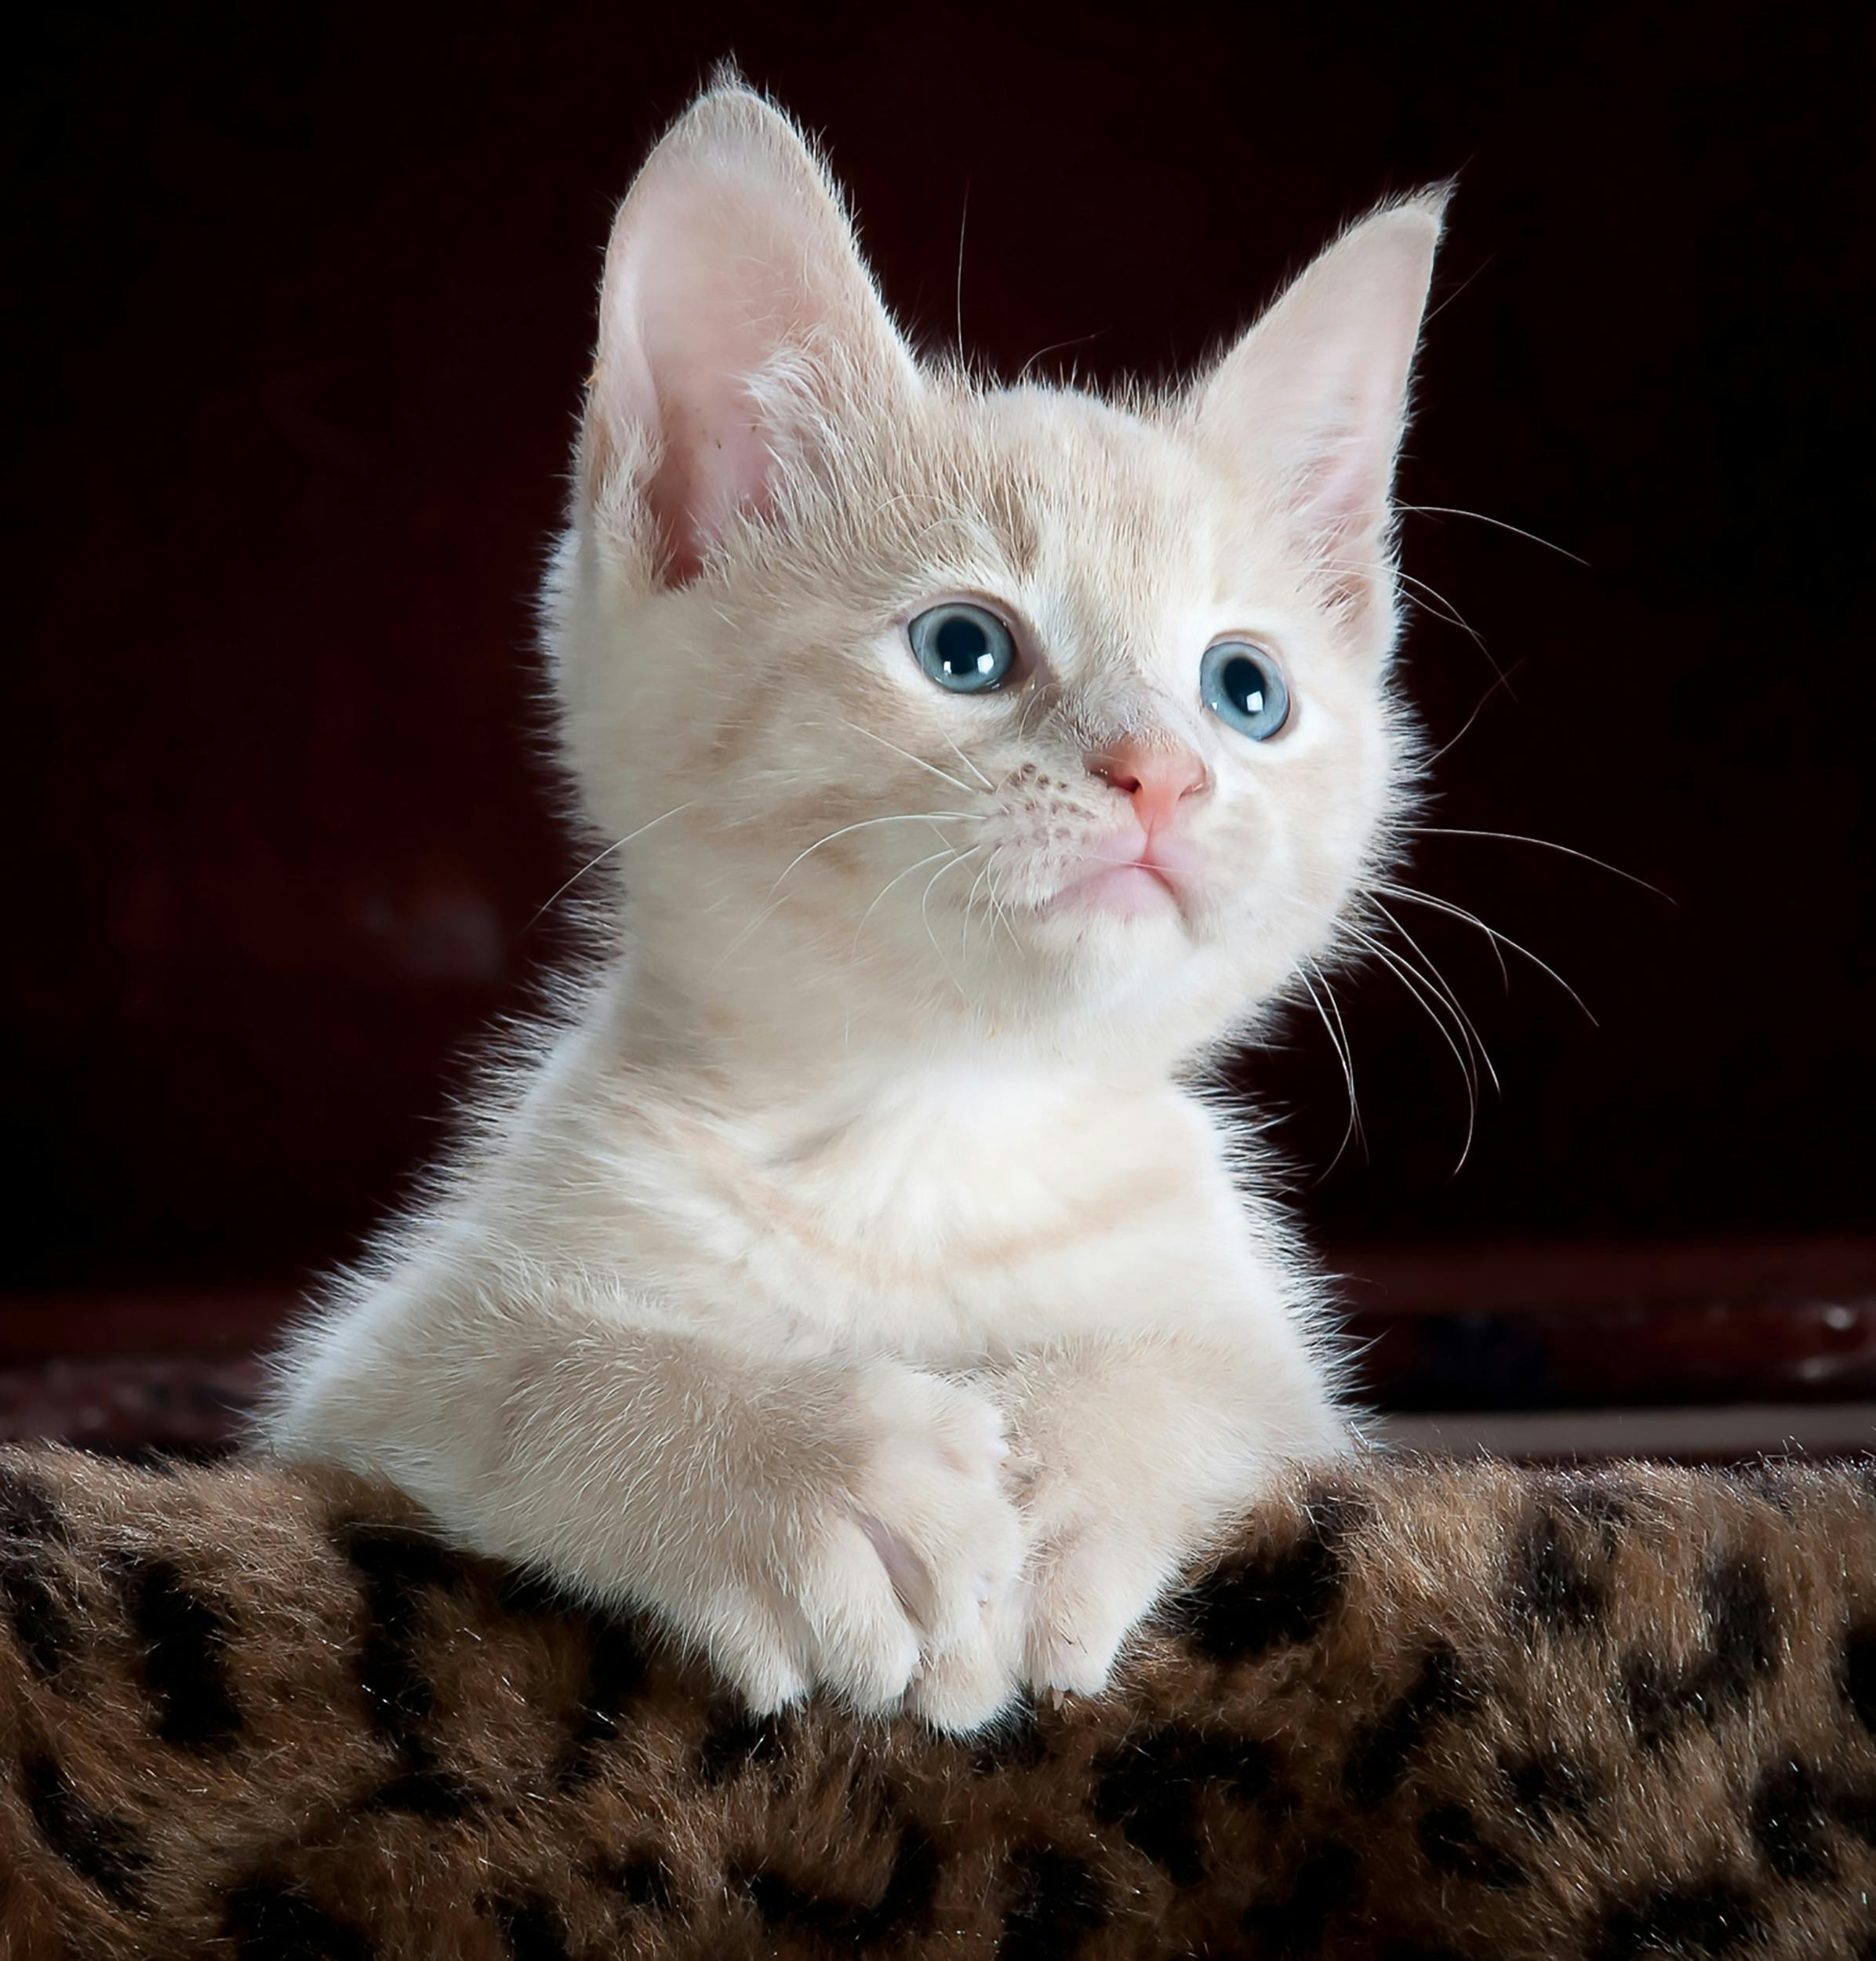

In [20]:
# Create folder if missing
os.makedirs("images", exist_ok=True)

# Example: display uploaded files
img_paths = glob.glob("images/car-image2.jpg")+ glob.glob("images/car2.jpg")+ glob.glob("images/car3.jpg")+ glob.glob("images/cat-image1.jpg")+ glob.glob("images/cat-image2.jpg")+ glob.glob("images/cat1.jpg")+ glob.glob("images/cat2.jpg")+ glob.glob("images/flower-image1.jpg")+ glob.glob("images/flower-image2.jpg")+ glob.glob("images/flower-image3.jpg")
print(f"Found {len(img_paths)} images")

# Quick preview
from IPython.display import Image as IPyImage, display
for path in img_paths[:5]:
    display(IPyImage(filename=path, width=150))


# Cell 5 — Compute embeddings

In [22]:
# Transform images for ImageBind
imgs_tensor = load_and_transform_vision_data(img_paths, device=device)

# Generate embeddings
with torch.no_grad():
    embeddings = model({ModalityType.VISION: imgs_tensor})[ModalityType.VISION]

emb_np = embeddings.cpu().numpy()
print("Embeddings shape:", emb_np.shape)


Embeddings shape: (10, 1024)


# Cell 6 — Dimensionality reduction (UMAP)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


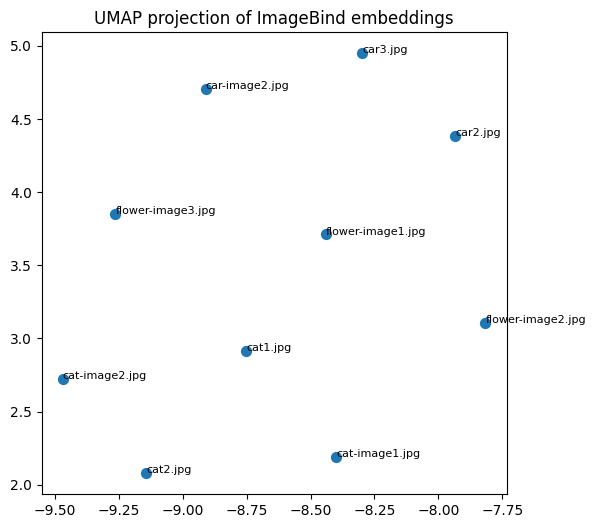

In [23]:
reducer = umap.UMAP(n_components=2, random_state=42)
emb2d = reducer.fit_transform(emb_np)

plt.figure(figsize=(6,6))
plt.scatter(emb2d[:,0], emb2d[:,1], s=50)
for i, p in enumerate(img_paths):
    plt.text(emb2d[i,0], emb2d[i,1], os.path.basename(p), fontsize=8)
plt.title("UMAP projection of ImageBind embeddings")
plt.show()


# Cell 7 — Cluster embeddings

In [24]:
# K-Means clustering
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
labels_km = km.fit_predict(emb_np)

# Density-based clustering (HDBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
labels_hdb = clusterer.fit_predict(emb_np)

print("KMeans labels:", np.unique(labels_km))
print("HDBSCAN labels:", np.unique(labels_hdb))


KMeans labels: [0 1 2]
HDBSCAN labels: [-1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Cell 8 — Visualize clusters

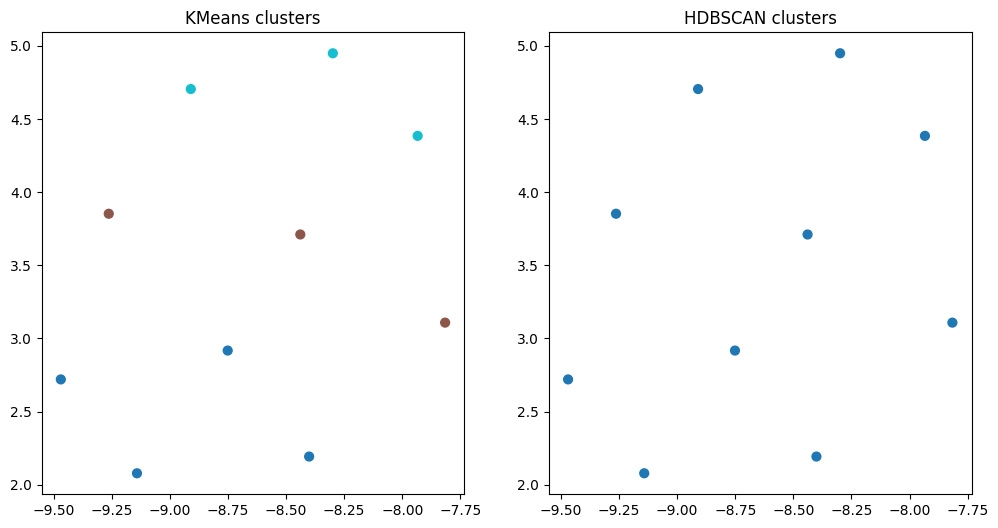

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(emb2d[:,0], emb2d[:,1], c=labels_km, cmap="tab10", s=40)
axes[0].set_title("KMeans clusters")

axes[1].scatter(emb2d[:,0], emb2d[:,1], c=labels_hdb, cmap="tab10", s=40)
axes[1].set_title("HDBSCAN clusters")

plt.show()


# Cell 9 — Inspect which images belong to each cluster

In [26]:
print("\n=== K-Means Clusters ===")
for c in sorted(set(labels_km)):
    print(f"\nCluster {c}:")
    for p, lbl in zip(img_paths, labels_km):
        if lbl == c:
            print("   ", os.path.basename(p))

print("\n=== HDBSCAN Clusters ===")
for c in sorted(set(labels_hdb)):
    print(f"\nCluster {c}:")
    for p, lbl in zip(img_paths, labels_hdb):
        if lbl == c:
            print("   ", os.path.basename(p))



=== K-Means Clusters ===

Cluster 0:
    cat-image1.jpg
    cat-image2.jpg
    cat1.jpg
    cat2.jpg

Cluster 1:
    flower-image1.jpg
    flower-image2.jpg
    flower-image3.jpg

Cluster 2:
    car-image2.jpg
    car2.jpg
    car3.jpg

=== HDBSCAN Clusters ===

Cluster -1:
    car-image2.jpg
    car2.jpg
    car3.jpg
    cat-image1.jpg
    cat-image2.jpg
    cat1.jpg
    cat2.jpg
    flower-image1.jpg
    flower-image2.jpg
    flower-image3.jpg


## Summary

- We cloned and used Meta AI’s **ImageBind** model to generate image embeddings.  
- Applied **K-Means** and **HDBSCAN** clustering algorithms to group visually similar images.  
- Reduced the embedding dimension with **UMAP** for visualization.  
- The resulting clusters represent semantically similar images, proving the power of LLM embeddings for image grouping tasks.

